In [161]:
############################# IMPORT STATEMENTS ########################################################
#Import Python modules
import numpy as np
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN
from numpy import asarray
from PIL import Image
from matplotlib.patches import Rectangle
import cv2
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

#For local CPU usage:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#Import Keras modules
from keras.layers import Dense, Flatten, Input, Dropout, Conv1D, Conv2D, LSTM, Concatenate, Reshape, MaxPool1D, MaxPool2D, BatchNormalization
from keras import Model, Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
import keras.backend as K
import tensorflow as tf
from scipy import stats

In [59]:
############################# SETUP PROJECT PARAMETERS ########################################################
LOAD_PROGRESS_FROM_MODEL = False
SAVE_PROGRESS_TO_MODEL = True

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

PATH_TO_FOLDER = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/AFEW/002'
PATH_TO_DATA = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/AFEW'
FOLDER = "/002"
DATA_DIR_PREDICT = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/facesdb/s005/tif/training/'
DISPLAY_IMG_NAME = '00000.png'
IMG_FORMAT = '.png'

# Approach:

### 1. Face detection
using MTCNN (Simultaneous face detection, face alignment, bounding boxing and landmark detection)

### 2. Highlighting faces
draw the bounding box in an image and plot it - to check out the result

### 3. Face extraction
extracting the face according to the identified bounding box

### 4. Face recognition
Using the VGGFace pretrained Resnet50 model to recognize emotions (training + prediction)

## 0. Get data

In [60]:
# for now reading the RGB values of the image (maybe in future just gray-scale)
def get_image_from_filename(path_to_folder, filename):
    image = cv2.cvtColor(cv2.imread(os.path.join(path_to_folder, filename)), cv2.COLOR_BGR2RGB)
    return image

def get_all_images(path_to_data):
    images = []
    for folder in os.listdir(path_to_data):
        for filename in os.listdir(os.path.join(path_to_data, folder)):
            img = cv2.imread(os.path.join(path_to_data, folder, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return images

In [61]:
# sructure data according to emotions (necessary to read in labels)
def get_labels_from_folder(path_to_data):
    labels = []
    
    for folder in os.listdir(path_to_data):
        with open(os.path.join(path_to_data, folder, folder + ".json")) as p:
            data = json.load(p)
        frames = data['frames']
    
        for key, value in frames.items():
            labels.append([value['valence'], value['arousal']])

    return labels

In [72]:
# split data into training, cv and test
def get_splitted_data(path_to_data):
    labels = get_labels_from_folder(path_to_data)
    filenames = get_all_images(path_to_data)
    
    filenames_shuffled_np, labels_shuffled_np = shuffle(filenames, labels)
    X_training, X_test, Y_training, Y_test = train_test_split(filenames_shuffled_np, labels_shuffled_np, test_size=0.2, random_state=1)
    
    return X_training, X_test, Y_training, Y_test

 
## 1. Face detection

In [87]:
detector = MTCNN()

def detect_face(image):
    face = detector.detect_faces(image)
    return face

def detect_faces(images):
    faces = []  
    for img in images:
        face = detector.detect_faces(img)
        if len(face) == 1:
            faces.append(face)  ## just use the face with the highest detection probability
        elif len(face) > 1:
            faces.append(face[0])
        else:
            faces.append([]) ### no face was detected
    return faces

In [88]:
image = get_image_from_filename(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
face = detect_face(image)
print(face)
len(face)

[{'box': [207, 157, 148, 222], 'confidence': 0.9956139326095581, 'keypoints': {'left_eye': (253, 254), 'right_eye': (321, 249), 'nose': (291, 310), 'mouth_left': (259, 337), 'mouth_right': (320, 331)}}]


1

## 2. Higlighting face

In [65]:
def highlight_face(path_to_folder, filename):
  # display image
    image = get_image_from_filename(path_to_folder, filename)
    plt.imshow(image)

    ax = plt.gca()
    face = detect_face(image)
    
    # for each face in the image, draw a rectangle based on coordinates
    for elem in face:
        x, y, width, height = elem['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

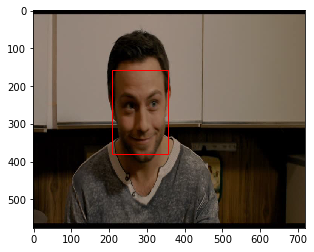

In [66]:
highlight_face(PATH_TO_FOLDER, DISPLAY_IMG_NAME)

## 3. Face extraction

In [103]:
def extract_face_from_image(image, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face = detect_face(image) # content of face is a python dict

    # extract the bounding box from the requested face
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height =  box
    
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
        
    return face_array


def extract_face_from_images(images, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    faces = detect_faces(images)
    face_images = []
    
    for i in range(len(images)):
        if faces[i-1] == []: # No face detected
            face_image = Image.fromarray(images[i-1])
            face_image = face_image.resize(required_size)
            face_array = asarray(face_image)
            face_images.append(face_array)
        else:
            # extract the bounding box from the requested face
            if type(faces[i-1]) is list:  # checks whether more than one face was detected
                box = np.asarray(faces[i-1][0]['box'])
                box[box < 0] = 0
                x1, y1, width, height = box
            else:
                box = np.asarray(faces[i-1]['box'])
                box[box < 0] = 0
                x1, y1, width, height = box

            x2, y2 = x1 + width, y1 + height
            # extract the face
            face_boundary = images[i-1][y1:y2, x1:x2]

            # resize pixels to the model size
            face_image = Image.fromarray(face_boundary)
            face_image = face_image.resize(required_size)
            face_array = asarray(face_image)
            face_images.append(face_array)
            
    return face_images

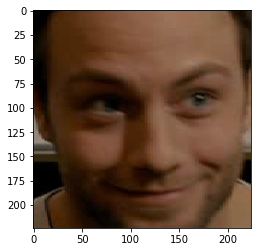

(224, 224, 3)

In [90]:
# Display the first face from the extracted faces
image = get_image_from_filename(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
extracted_face = extract_face_from_image(image)
plt.imshow(extracted_face)
plt.show()
extracted_face.shape

## 4. Face recognition -> Emotions

In [91]:
def get_face_embedding(faces):
    samples = asarray(faces, 'float32')

    # prepare the data for the model
    samples = preprocess_input(samples, version=2)

    # create a vggface model object
    model = VGGFace(model='resnet50',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg')
    
    # perform prediction
    return model.predict(samples)

In [112]:
X_training, X_test, Y_train, Y_test = get_splitted_data(PATH_TO_DATA)

In [114]:
print(len(X_training))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

80
20
80
20


In [115]:
X_train_faces = extract_face_from_images(X_training)
X_test_faces = extract_face_from_images(X_test)

X_train_embeddings = get_face_embedding(X_train_faces)
X_test_embeddings = get_face_embedding(X_test_faces)

In [116]:
np.savetxt('X_train_embeddings.txt', X_train_embeddings)
np.savetxt('X_test_embeddings.txt', X_test_embeddings)

np.savetxt('Y_train.txt', Y_train)
np.savetxt('Y_test.txt', Y_test)

In [117]:
X_train_embeddings = np.loadtxt('X_train_embeddings.txt')
X_test_embeddings = np.loadtxt('X_test_embeddings.txt')

Y_train = np.loadtxt('Y_train.txt')
Y_test = np.loadtxt('Y_test.txt')

In [118]:
#the model returns a vector, which represents the features of a face
print(X_train_embeddings)
print(X_train_embeddings.shape)

[[7.50076771e-01 0.00000000e+00 1.54107785e+00 ... 3.25518870e+00
  1.09365904e+00 3.07581067e+00]
 [1.99473381e-01 2.67033204e-02 3.56754112e+00 ... 5.29538965e+00
  1.46855569e+00 4.18634367e+00]
 [5.56414247e-01 4.51800041e-03 3.56992602e+00 ... 8.60082150e-01
  1.57693696e+00 3.26512575e+00]
 ...
 [3.26062053e-01 5.32325415e-04 3.15904665e+00 ... 1.23570693e+00
  2.06189251e+00 3.15717745e+00]
 [0.00000000e+00 0.00000000e+00 5.16212359e-02 ... 4.66405600e-01
  6.13839805e-01 0.00000000e+00]
 [6.94436952e-03 8.24478921e-03 3.26773596e+00 ... 1.84041119e+00
  5.52793682e-01 4.15884161e+00]]
(80, 2048)


In [119]:
def model_top(input_shape):
    model = Sequential()
        
    model.add(Dense(512, activation='relu', input_dim = input_shape))
    model.add(Dropout(0.1))
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim = 2, activation='tanh')) 
    
    return model

In [120]:
Y_train = np.asarray(Y_train)

In [121]:
print(X_train_embeddings.shape)
print(Y_train.shape)

model = model_top(X_train_embeddings.shape[1])

(80, 2048)
(80, 2)


c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", units=2)`
  del sys.path[0]


In [122]:
if LOAD_PROGRESS_FROM_MODEL:
    model.load_weights("model_checkpoints/model_top.h5")
    print("Loaded model from disk")

In [190]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [185]:
def corr(y_true, y_pred):
    #normalise
    n_y_true = (y_true - K.mean(y_true[:])) / K.std(y_true[:])
    n_y_pred = (y_pred - K.mean(y_pred[:])) / K.std(y_pred[:])  

    top=K.sum((n_y_true[:]-K.mean(n_y_true[:]))*(n_y_pred[:]-K.mean(n_y_pred[:])),axis=[-1,-2])
    bottom=K.sqrt(K.sum(K.pow((n_y_true[:]-K.mean(n_y_true[:])),2),axis=[-1,-2])*K.sum(K.pow(n_y_pred[:]-K.mean(n_y_pred[:]),2),axis=[-1,-2]))

    result=top/bottom
    return K.mean(result)

In [186]:
def corr_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)



In [187]:
model.summary()
model.compile(loss = corr_loss, optimizer = "adam", metrics = ["accuracy", root_mean_squared_error, corr])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_53 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_54 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_55 (Dense)             (None, 2)                

In [188]:
# train model 
batch_size = 32
model.fit(
    X_train_embeddings, 
    Y_train,
    epochs=10,
    verbose=1,
    validation_data=(X_test_embeddings, Y_test),
    validation_steps = int(X_test_embeddings.shape[0] // batch_size))

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 3s 43ms/step - loss: 0.4135 - accuracy: 0.6125 - root_mean_squared_error: 3.1025 - corr: 0.7574 - val_loss: 0.9975 - val_accuracy: 0.7000 - val_root_mean_squared_error: 3.1525 - val_corr: 0.0504
Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4094 - accuracy: 0.6250 - root_mean_squared_error: 3.0249 - corr: 0.7763 - val_loss: 0.9876 - val_accuracy: 0.7000 - val_root_mean_squared_error: 2.9588 - val_corr: -0.1113
Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.6375 - root_mean_squared_error: 3.1198 - corr: 0.7272 - val_loss: 0.9982 - val_accuracy: 0.7000 - val_root_mean_squared_error: 2.9703 - val_corr: -0.0429
Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4355 - accuracy: 0.6250 - root_mean_squared_error: 3.1247 - corr: 0.7521 - val_loss: 0.9943 - val_accuracy: 0.7000 - val_root_mean_squared_er

In [189]:
if SAVE_PROGRESS_TO_MODEL:
    model.save_weights("model_checkpoints/model_top.h5")
    print("Saved model to disk")

Saved model to disk


In [136]:
### PREDICTION

In [138]:
emotion_scores = model.predict(X_test_embeddings)

In [139]:
# the model returns the emtions in 2-dimensional Valance-Arousal space
print(emotion_scores)

[[0.99998695 0.99983275]
 [0.9999988  0.9999997 ]
 [0.99997723 0.99977726]
 [0.99999726 0.9999995 ]
 [0.99999803 0.9999695 ]
 [0.99999785 0.9999996 ]
 [0.999983   0.9998684 ]
 [0.9999985  0.9999771 ]
 [0.999995   0.99993503]
 [0.9999882  0.99996454]
 [0.9999948  0.99986416]
 [0.99999696 0.99999934]
 [0.9999894  0.99999905]
 [0.99999064 0.9998894 ]
 [0.99999785 0.99999964]
 [0.99999636 0.99984926]
 [0.9999278  0.9996679 ]
 [0.9999962  0.9998706 ]
 [0.99999744 0.9999994 ]
 [0.99998343 0.9999043 ]]
